# Part 2 - Patient similarity networks

10. **Patient Similarity Network Construction**

11. **DNA Methylation Network Analysis** 

In [4]:
# standard libraries
import os
import pickle

# scientific and data manipulation libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from astropy.stats import median_absolute_deviation
import mygene
import astropy

# graph and network libraries
import networkx as nx

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# import custom functions from the previous notebook
import sys
sys.path.insert(0 , '/tutorial/')
# from functions import *

In [19]:

def filter_low_expression_genes(data, threshold=1.0):
    """
    Filter out low-expressed genes from the dataset.

    Calculates the mean expression level for each gene and filters out
    genes whose mean expression level is below the specified threshold.

    Parameters:
    data (DataFrame): Expression data with genes as columns.
    threshold (float): Minimum mean expression level to retain a gene.
                       Default is 1.0.

    Returns:
    DataFrame: Filtered data with genes above the threshold.
    """
    # Calculate the mean expression for each gene
    gene_means = data.mean(axis=0)
    # Filter out genes with mean expression below the threshold
    mask = gene_means >= threshold
    filtered_data = data.loc[:, mask]
    return filtered_data


def filter_high_variance_genes(data, threshold):
    """
    Filter out genes with variance below the specified threshold.

    Calculates the variance for each gene and filters out genes whose 
    variance is below the specified threshold.

    Parameters:
    data (DataFrame): Gene expression data with genes as columns and samples as rows.
    threshold (float): Minimum variance level to retain a gene.

    Returns:
    DataFrame: Filtered data with genes having variance above the threshold.
    """

    # Calculate the variance for each gene (column)
    gene_variances = data.var(axis=0)
    # Create a boolean mask to filter out genes with variance below the threshold
    mask = gene_variances >= threshold
    # Apply the mask to filter the DataFrame
    filtered_data = data.loc[:, mask]
    return filtered_data

def calc_abs_bicorr(data):
    """
    Calculate the absolute biweight midcorrelation matrix for numeric data.

    Parameters:
    data (pd.DataFrame): Input DataFrame with numeric data.

    Returns:
    pd.DataFrame: DataFrame containing the absolute biweight midcorrelation matrix.
    """

    # Select only numeric data
    data = data._get_numeric_data()
    cols = data.columns
    idx = cols.copy()
    mat = data.to_numpy(dtype=float, na_value=np.nan, copy=False)
    mat = mat.T

    K = len(cols)
    correl = np.empty((K, K), dtype=np.float32)

    # Calculate biweight midcovariance
    bicorr = astropy.stats.biweight_midcovariance(mat, modify_sample_size=True)

    for i in range(K):
        for j in range(K):
            if i == j:
                correl[i, j] = 1.0
            else:
                denominator = np.sqrt(bicorr[i, i] * bicorr[j, j])
                if denominator != 0:
                    correl[i, j] = bicorr[i, j] / denominator
                else:
                    correl[i, j] = 0  # Or handle it in another appropriate way

    return pd.DataFrame(data=np.abs(correl), index=idx, columns=cols, dtype=np.float32)


def create_graph_from_correlation(correlation_matrix, threshold=0.8):
    """
    Creates a graph from a correlation matrix using a specified threshold.

    Parameters:
    correlation_matrix (pd.DataFrame): DataFrame containing the correlation matrix.
    threshold (float): Threshold for including edges based on correlation value.

    Returns:
    G (nx.Graph): Graph created from the correlation matrix.
    """
    G = nx.Graph()

    # Add nodes
    for node in correlation_matrix.columns:
        G.add_node(node)

    # Add edges with weights above the threshold
    for i in range(correlation_matrix.shape[0]):
        for j in range(i + 1, correlation_matrix.shape[1]):
            if i != j:  # Ignore the diagonal elements
                weight = correlation_matrix.iloc[i, j]
                if abs(weight) >= threshold:
                    G.add_edge(correlation_matrix.index[i], correlation_matrix.columns[j], weight=weight)

    return G


def print_graph_info(G):
    """
    Print basic information about a NetworkX graph.

    
    Parameters:
    G (nx.Graph): The NetworkX graph.
    """
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print("Sample nodes:", list(G.nodes)[:10])  # Print first 10 nodes as a sample
    print("Sample edges:", list(G.edges(data=True))[:10])  # Print first 10 edges as a sample
    
    info_str = "Graph type: "
    is_directed = G.is_directed()
    if is_directed:
        info_str += "directed"
    else:
        info_str += "undirected"
    print(info_str)

    # Check for self-loops
    self_loops = list(nx.selfloop_edges(G))
    if self_loops:
        print(f"Number of self-loops: {len(self_loops)}")
        print("Self-loops:", self_loops)
    else:
        print("No self-loops in the graph.")

    # density of the graph
    density = nx.density(G)
    print(f"Graph density: {density}")

    # Find and print the number of connected components
    num_connected_components = nx.number_connected_components(G)
    print(f"Number of connected components: {num_connected_components}")

    # Calculate and print the clustering coefficient of the graph
    clustering_coeff = nx.average_clustering(G)
    print(f"Average clustering coefficient: {clustering_coeff}")


# Function to visualize the graph
def visualise_graph(G, title='Gene Co-expression Network'):
    """
    Visualizes the graph using Matplotlib and NetworkX.

    Parameters:
    G (nx.Graph): Graph to visualize.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.1)  # k controls the distance between nodes
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.5)
    plt.title(title)
    plt.show()


def clean_graph(G, degree_threshold=1, keep_largest_component=True):
    """
    Cleans the graph by performing several cleaning steps:
    - Removes unconnected nodes (isolates)
    - Removes self-loops
    - Removes nodes with a degree below a specified threshold
    - Keeps only the largest connected component (optional)

    Parameters:
    G (nx.Graph): The NetworkX graph to clean.
    degree_threshold (int): Minimum degree for nodes to keep.
    keep_largest_component (bool): Whether to keep only the largest connected component.

    Returns:
    G (nx.Graph): Cleaned graph.
    """
    G = G.copy()  # Work on a copy of the graph to avoid modifying the original graph

    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # Remove nodes with no edges (isolates)
    G.remove_nodes_from(list(nx.isolates(G)))

    # Remove nodes with degree below the threshold
    low_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree < degree_threshold]
    G.remove_nodes_from(low_degree_nodes)

    # Keep only the largest connected component
    if keep_largest_component:
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    return G


def plot_degree_distribution(G):
    """
    Plots the degree distribution of the graph.
    
    Parameters:
    G (nx.Graph): The NetworkX graph.
    """
    degrees = [d for n, d in G.degree()]
    plt.figure(figsize=(10, 6))
    sns.histplot(degrees, bins=30, kde=False, edgecolor='black')
    plt.title('Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()

def visualise_edge_weight_distribution(G):
    """
    Visualizes the distribution of edge weights.

    Parameters:
    edge_weights (list): List of edge weights.
    """
    plt.figure(figsize=(10, 6))
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    # Histogram
    sns.histplot(edge_weights, bins=30, kde=False)
    
    plt.title('Distribution of Edge Weights')
    plt.xlabel('Edge Weight')
    plt.ylabel('Frequency')
    plt.show()

def threshold_sparsification(graph, threshold):
    """
    Sparsifies the graph by removing edges below the specified weight threshold.

    Parameters:
    graph (nx.Graph): The original NetworkX graph.
    threshold (float): The weight threshold.

    Returns:
    nx.Graph: The sparsified graph.
    """
    graph_copy = graph.copy()
    sparsified_graph = nx.Graph()
    sparsified_graph.add_nodes_from(graph_copy.nodes(data=True))
    sparsified_graph.add_edges_from((u, v, d) for u, v, d in graph_copy.edges(data=True) if d.get('weight', 0) >= threshold)
    return sparsified_graph

def top_percentage_sparsification(graph, top_percentage):
    """
    Sparsifies the graph by keeping the top percentage of edges by weight.

    Parameters:
    graph (nx.Graph): The original NetworkX graph.
    top_percentage (float): The percentage of top-weight edges to keep.

    Returns:
    nx.Graph: The sparsified graph.
    """
    graph_copy = graph.copy()
    sorted_edges = sorted(graph_copy.edges(data=True), key=lambda x: x[2].get('weight', 0), reverse=True)
    top_edges_count = max(1, int(len(sorted_edges) * (top_percentage / 100)))
    sparsified_graph = nx.Graph()
    sparsified_graph.add_nodes_from(graph_copy.nodes(data=True))
    sparsified_graph.add_edges_from(sorted_edges[:top_edges_count])
    return sparsified_graph


def remove_by_degree(graph, min_degree):
    """
    Sparsifies the graph by removing nodes with degree below the specified threshold.

    Parameters:
    graph (nx.Graph): The original NetworkX graph.
    min_degree (int): The minimum degree threshold.

    Returns:
    nx.Graph: The sparsified graph.
    """
    graph_copy = graph.copy()
    nodes_to_remove = [node for node, degree in dict(graph_copy.degree()).items() if degree < min_degree]
    
    graph_copy.remove_nodes_from(nodes_to_remove)
    return graph_copy

def knn_sparsification(graph, k):
    """
    Sparsifies the graph by keeping only the top-k edges with the highest weights for each node.

    Parameters:
    graph (nx.Graph): The original NetworkX graph.
    k (int): The number of nearest neighbors to keep for each node.

    Returns:
    nx.Graph: The sparsified graph.
    """
    graph_copy = graph.copy()
    sparsified_graph = nx.Graph()
    sparsified_graph.add_nodes_from(graph_copy.nodes(data=True))
    
    for node in graph_copy.nodes():
        edges = sorted(graph_copy.edges(node, data=True), key=lambda x: x[2].get('weight', 0), reverse=True)
        sparsified_graph.add_edges_from(edges[:k])
    
    return sparsified_graph


def spanning_tree_sparsification(graph):
    """
    Sparsifies the graph by creating a minimum spanning tree.

    Parameters:
    graph (nx.Graph): The original NetworkX graph.

    Returns:
    nx.Graph: The sparsified graph.
    """
    graph_copy = graph.copy()
    return nx.minimum_spanning_tree(graph_copy, weight='weight')

def analyse_and_plot_density(graph):
    """
    Calculates and plots the density of the graph for a predefined series of thresholds.

    Parameters:
    graph (nx.Graph): The original NetworkX graph.

    Returns:
    densities (list of float): Densities of the graph at each threshold.
    """
    thresholds = [0.7 + i * 0.01 for i in range(31)]
    densities = []

    for threshold in thresholds:
        filtered_edges = [(u, v) for u, v, d in graph.edges(data=True) if d['weight'] > threshold]
        temp_graph = nx.Graph()
        temp_graph.add_edges_from(filtered_edges)
        densities.append(nx.density(temp_graph))

    # Plot the densities
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, densities, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Density')
    plt.title('Density vs. Threshold')
    plt.grid(True)
    plt.show()

    return densities

def get_highest_degree_nodes(graph, top_n=10):
    """
    Returns the nodes with the highest degree in the graph.

    Parameters:
    graph (nx.Graph): The NetworkX graph.
    top_n (int): The number of top nodes to return.

    Returns:
    List of tuples: Each tuple contains a node and its degree.
    """
    degrees = dict(graph.degree())
    sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    return sorted_degrees[:top_n]

def fetch_gene_info(gene_list):
    """
    Fetches gene information from MyGene.info.

    Parameters:
    gene_list (list): List of gene symbols or Ensembl IDs.

    Returns:
    list: List of dictionaries containing gene information.
    """
    mg = mygene.MyGeneInfo()
    gene_info = mg.querymany(gene_list, scopes='symbol,ensembl.gene', 
                             fields='name,symbol,entrezgene,summary,disease,pathway', 
                             species='human')
    return gene_info

def print_gene_info_with_degree(top_genes_with_degrees, gene_info):
    """
    Prints gene information including the degree.

    Parameters:
    top_genes_with_degrees (list): List of tuples containing gene symbols and their degrees.
    gene_info (list): List of dictionaries containing gene information.
    """
    for gene, degree in top_genes_with_degrees:
        info = next((item for item in gene_info if item['query'] == gene), None)
        if info:
            print(f"Gene Symbol: {info.get('symbol', 'N/A')}")
            print(f"Degree: {degree}")
            print(f"Gene Name: {info.get('name', 'N/A')}")
            print(f"Entrez ID: {info.get('entrezgene', 'N/A')}")
            print(f"Summary: {info.get('summary', 'N/A')}")
            if 'disease' in info:
                diseases = ', '.join([d['term'] for d in info['disease']])
                print(f"Diseases: {diseases}")
            else:
                print("Diseases: N/A")
            if 'pathway' in info:
                pathways = []
                if isinstance(info['pathway'], dict):
                    for key in info['pathway']:
                        pathway_data = info['pathway'][key]
                        if isinstance(pathway_data, list):
                            pathways.extend([p['name'] for p in pathway_data if 'name' in p])
                        elif isinstance(pathway_data, dict) and 'name' in pathway_data:
                            pathways.append(pathway_data['name'])
                        elif isinstance(pathway_data, str):
                            pathways.append(pathway_data)
                print(f"Pathways: {', '.join(pathways) if pathways else 'N/A'}")
            else:
                print("Pathways: N/A")
            print("-" * 40)
        else:
            print(f"Gene not found: {gene}")
            print(f"Degree: {degree}")
            print("-" * 40)



# 10. Patient Similarity Network

- Based on the same expression matrix we can create a patient similarity network.
- Transposing the matrix will switch the rows and columns,
- meaning that patients will become the columns instead of genes
- By doing this, you can compute the correlation (or similarity) between patients based on their gene expression profiles,
- and then create a network where nodes represent patients and edges represent similarities.

In [5]:
# main data directories for the project

raw_data_dir = '/data/raw'
intermediate_data_dir = '/data/intermediate'

In [6]:
# read in os.path.join(intermediate_data_dir,"expression_data_filtered.csv")
df_renamed = pd.read_csv(os.path.join(intermediate_data_dir,
                                      "expression_data_filtered.csv"),
                                      index_col=0)

In [11]:
'''
#################################################
                YOUR CODE HERE
#################################################

We will now transpose the df_renamed df so that the rows represent the genes and the columns represent the patients.
Let's call the transposed df patient_gene_matrix.

'''

patient_gene_matrix = df_renamed.T

In [12]:
patient_gene_matrix

,TCGA-38-7271,TCGA-55-7914,TCGA-95-7043,TCGA-73-4658,TCGA-86-8076,TCGA-55-7726,TCGA-44-6147,TCGA-50-5932,TCGA-44-2661,TCGA-86-7954,...,TCGA-97-A4M7,TCGA-62-A46R,TCGA-50-5055,TCGA-38-4628,TCGA-86-7713,TCGA-86-8073,TCGA-MN-A4N4,TCGA-53-7626,TCGA-44-A47G,TCGA-55-6969
A2M,17.7492,14.8513,14.1691,16.7238,15.6783,14.7566,16.4368,15.5476,15.5478,15.1337,...,15.9553,13.9511,16.3097,14.3934,15.8254,16.3773,14.9411,16.7343,15.6622,14.8136
A2ML1,4.4411,4.4530,4.5026,3.1704,4.7422,6.0918,4.0602,3.0827,3.4608,3.6367,...,4.7076,2.4821,8.0810,3.3415,5.3379,4.0817,6.7210,5.2575,3.7345,4.3058
A4GALT,10.1862,8.9312,9.0834,9.1443,9.5150,11.4452,9.1462,7.3597,9.1602,8.9344,...,9.1019,8.6653,10.8837,8.6304,9.3827,9.4234,11.9107,9.5379,9.8660,9.7702
AACSP1,3.5845,3.6762,3.8623,2.4821,3.2271,2.4821,5.6614,3.0827,3.9428,4.7089,...,5.4947,3.0956,2.4821,3.7710,2.9397,6.6519,8.8283,2.4821,4.1045,6.8425
AADAC,9.6415,6.5685,5.5634,4.3206,7.2321,6.8821,8.1176,4.7935,11.7750,7.0644,...,9.0856,3.8162,5.6471,4.6785,4.6578,6.7641,3.4947,5.7120,6.2214,5.2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN23,5.7385,4.3796,5.6728,3.6533,5.0478,6.0489,5.8058,3.7897,4.3451,5.5259,...,4.7076,2.4821,4.6683,3.4697,4.3516,7.2074,6.9167,6.0927,5.3854,3.6792
ZSCAN31,9.0817,10.9565,10.8095,8.9874,9.5810,9.0185,10.2085,9.8803,11.0327,10.2707,...,9.2033,10.5020,8.8073,9.8672,10.6419,10.2410,9.4672,10.0507,7.4843,8.5268
ZSCAN4,3.2709,3.0918,2.4821,3.4468,3.0118,5.0894,5.5341,3.5082,5.4987,3.3645,...,4.4088,7.4937,4.3167,5.0907,6.7676,5.1126,3.3143,4.2816,4.4650,2.4821
ZWINT,9.2615,10.1334,10.9149,9.7828,8.6640,11.1212,9.0718,10.7305,9.0013,10.4268,...,9.7614,10.7593,9.7087,10.4729,10.9794,10.1390,10.0583,9.4627,9.5817,10.8228


In [14]:
'''
#################################################
                YOUR CODE HERE
#################################################

We will now calculate the correlation matrix for the patient_gene_matrix using the Pearson correlation method.
Store the correlation matrix in a dictionary called patient_correlation_matrices with the key 'pearson'.
We don't have to do it, however if you want to calculate the correlation matrix using other methods,
you can do so and store them in the dictionary as well.

'''

# Dictionary to store different correlation matrices
patient_correlation_matrices = {}

# Pearson correlation
patient_correlation_matrices['pearson'] = patient_gene_matrix.corr(method='pearson')

In [15]:
'''
#################################################
                YOUR CODE HERE
#################################################

Create a graph from the correlation matrix using the create_graph_from_correlation function.
Set the threshold to 0.8.
Store the graph in a variable called patient_pearson_graph.

'''

patient_pearson_graph = create_graph_from_correlation(patient_correlation_matrices['pearson'], threshold=0.8)

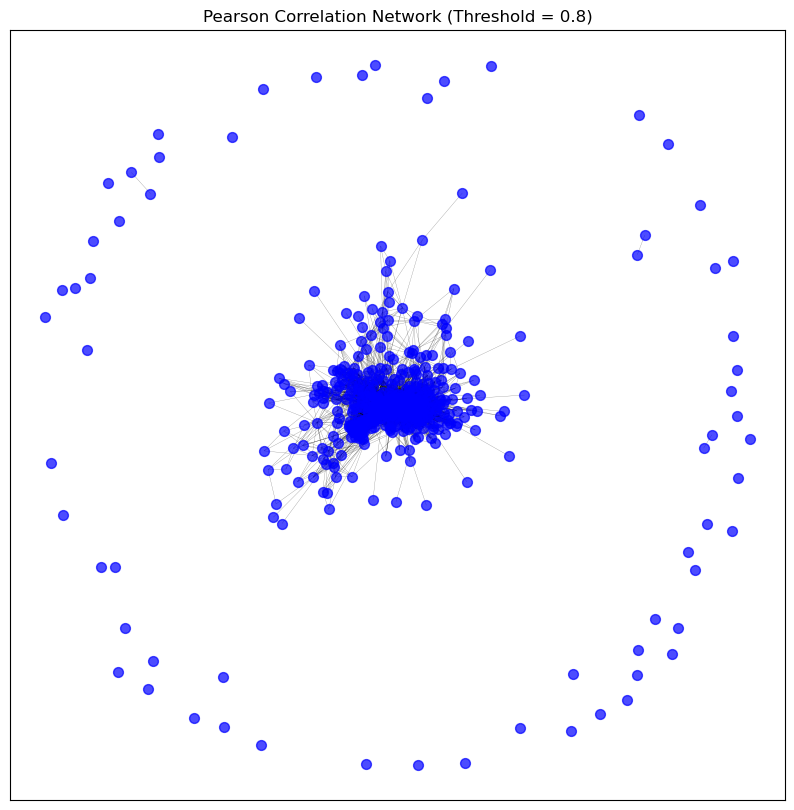

In [20]:
'''
#################################################
                YOUR CODE HERE
#################################################

Visualie the graph using the visualise_graph function.
Use appropriate title for the graph as the second argument.

'''
visualise_graph(patient_pearson_graph, title='Pearson Correlation Network (Threshold = 0.8)')

In [23]:
'''
#################################################
                YOUR CODE HERE
#################################################

Now use clean_graph function to clean the graph called patient_pearson_graph_pruned.
Consider the following parameters:
- degree_threshold
- keep_largest_component

'''
patient_pearson_graph_pruned = clean_graph(patient_pearson_graph,
                                    degree_threshold=1,
                                    keep_largest_component=True)

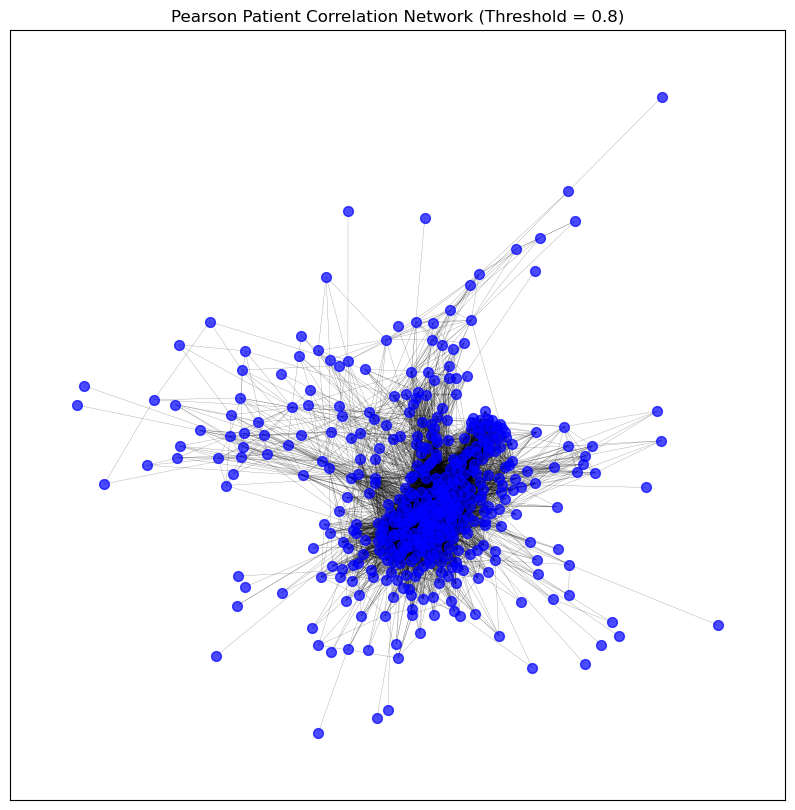

In [22]:
'''
#################################################
                YOUR CODE HERE
#################################################

Visualie the pruned graph using the visualise_graph function.
Use appropriate title for the graph as the second argument.

'''

visualise_graph(patient_pearson_graph_pruned,
                title='Pearson Patient Correlation Network (Threshold = 0.8)')

In [25]:
'''
#################################################
                YOUR CODE HERE
#################################################

 Now do some sparseification of the graph using knn_sparsification function,
 call it patient_pearson_graph_pruned_knn.
 Set the k value to 10.               

'''

patient_pearson_graph_pruned_knn = knn_sparsification(patient_pearson_graph_pruned, k=10)

In [28]:
'''
#################################################
                YOUR CODE HERE
#################################################

Let's see some information about the graph using the print_graph_info function.
First, print the information about the patient_pearson_graph_pruned graph.
Use print("------------------------------------"), as a devide between the two graphs.
Then, print the information about the patient_pearson_graph_pruned_knn graph.            

'''

print_graph_info(patient_pearson_graph_pruned)
print("------------------------------------")
print_graph_info(patient_pearson_graph_pruned_knn)

Number of nodes: 434
Number of edges: 10373
Sample nodes: ['TCGA-38-7271', 'TCGA-55-7914', 'TCGA-73-4658', 'TCGA-86-8076', 'TCGA-55-7726', 'TCGA-44-6147', 'TCGA-50-5932', 'TCGA-44-2661', 'TCGA-86-7954', 'TCGA-73-4662']
Sample edges: [('TCGA-38-7271', 'TCGA-73-4658', {'weight': 0.8696511707884843}), ('TCGA-38-7271', 'TCGA-86-8076', {'weight': 0.8173779911639248}), ('TCGA-38-7271', 'TCGA-44-2661', {'weight': 0.8652686243802332}), ('TCGA-38-7271', 'TCGA-73-4662', {'weight': 0.8446135021161085}), ('TCGA-38-7271', 'TCGA-55-6986', {'weight': 0.833876175940164}), ('TCGA-38-7271', 'TCGA-49-6744', {'weight': 0.8919809060862212}), ('TCGA-38-7271', 'TCGA-69-7763', {'weight': 0.8374050473870502}), ('TCGA-38-7271', 'TCGA-44-6774', {'weight': 0.802120255633156}), ('TCGA-38-7271', 'TCGA-67-3774', {'weight': 0.8179727328277505}), ('TCGA-38-7271', 'TCGA-97-A4M2', {'weight': 0.8045412817214057})]
Graph type: undirected
No self-loops in the graph.
Graph density: 0.11039686678515555
Number of connected co

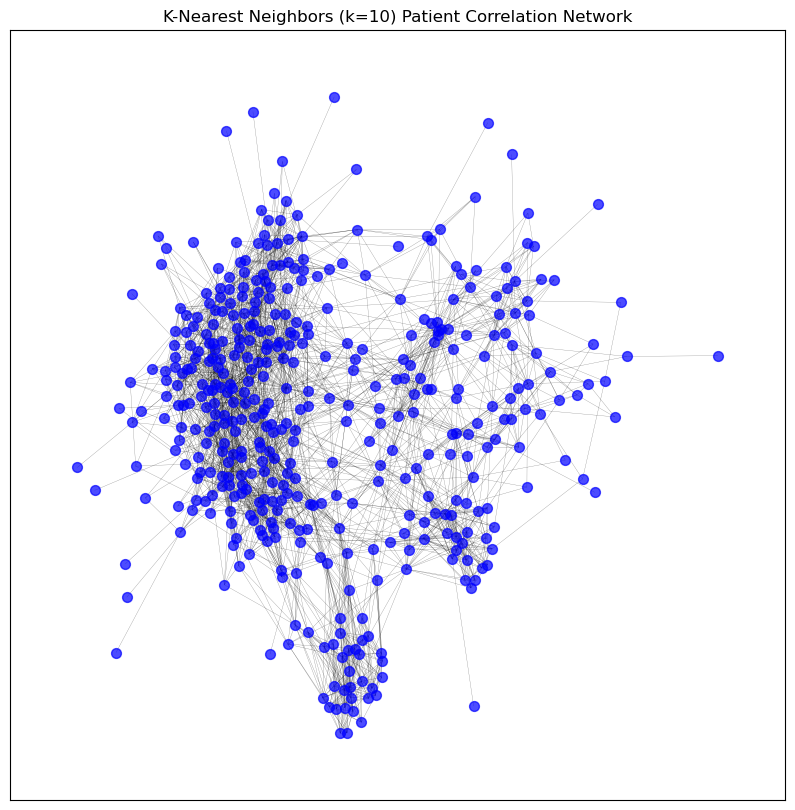

In [29]:
visualise_graph(patient_pearson_graph_pruned_knn, title='K-Nearest Neighbors (k=10) Patient Correlation Network')

# 11. DNA methylation PSN

In the second task, we are preparing an additional network for the same patients, this time based on DNA methylation data.

In [31]:
# Load the data using pickle from the ISMB_TCGA_DNAm.pkl file
with open(os.path.join(raw_data_dir,"ISMB_TCGA_DNAm.pkl") , 'rb') as file : 
    data = pd.read_pickle(file)

# Extract the methylation data from the dictionary similar to the previous data
meth_data = data["datExpr"]
meth_data


,cg23057992,cg16602369,cg20545544,cg04571941,cg23091104,cg11738485,cg17735539,cg12662576,cg10554839,cg08866780,...,cg04339424,cg01318691,cg27068965,cg23028848,cg21122529,cg22254072,cg10237911,cg09874052,cg27624178,cg02857943
TCGA-55-7914,0.039144,0.078881,0.032201,0.098520,0.971626,0.020020,0.929670,0.033325,0.043767,0.028051,...,0.053027,0.046047,0.951328,0.045767,0.048185,0.014262,0.034541,0.034967,0.041538,0.053116
TCGA-38-4631,0.954805,0.047287,0.027976,0.925794,0.144636,0.365842,0.156414,0.027917,0.047609,0.049901,...,0.048398,0.047221,0.939891,0.056141,0.047459,0.014548,0.056591,0.039086,0.044946,0.055473
TCGA-73-4658,0.966071,0.126549,0.030316,0.945166,0.976080,0.975638,0.942018,0.066659,0.052100,0.047054,...,0.040815,0.042040,0.951235,0.045477,0.074037,0.019053,0.029978,0.039345,0.060650,0.041385
TCGA-50-5932,0.965140,0.061194,0.935457,0.923421,0.965443,0.027598,0.040885,0.036178,0.045745,0.046439,...,0.057840,0.045106,0.948255,0.044558,0.039484,0.013837,0.037048,0.032503,0.058576,0.037666
TCGA-55-7576,0.958612,0.071607,0.027077,0.940574,0.976870,0.785073,0.953674,0.945107,0.056088,0.955472,...,0.046921,0.051442,0.954000,0.034352,0.031497,0.014924,0.035520,0.043547,0.056388,0.052208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-50-8457,0.960316,0.940219,0.046927,0.942980,0.977751,0.633731,0.940723,0.053398,0.059292,0.968875,...,0.047640,0.062680,0.954824,0.043137,0.048599,0.014066,0.031109,0.039247,0.035110,0.054273
TCGA-91-6840,0.964250,0.921250,0.957943,0.958416,0.981439,0.278432,0.968525,0.032143,0.083996,0.037912,...,0.045197,0.066271,0.963420,0.047621,0.060854,0.015823,0.045674,0.040006,0.052008,0.040826
TCGA-86-8280,0.948855,0.942925,0.958506,0.945667,0.970511,0.544447,0.921924,0.939427,0.082121,0.045036,...,0.062367,0.058898,0.954355,0.045702,0.048930,0.019321,0.039341,0.036627,0.054269,0.056795
TCGA-95-A4VK,0.037255,0.050940,0.036565,0.098237,0.976780,0.683394,0.960073,0.025232,0.062487,0.026908,...,0.056248,0.053591,0.947020,0.035344,0.057783,0.010943,0.051868,0.035566,0.044910,0.042269


In [ ]:
# load the data from the pickle file
with open(os.path.join(raw_data_dir,"ISMB_TCGA_GE.pkl"), 'rb') as file:
    GE_data = pickle.load(file)


In [ ]:
GE_data["datMeta"]["patient"].to_list()

1. Load the smoking-related DNA methylation data from a tab-separated values (TSV) file. (os.path.join(raw_data_dir,"smoking.tsv"))
2. Identify CpG sites that are commonly annotated in the smoking dataset
3. Filter the DNA methylation data to include only the common CpG sites identified in the previous step
4. Identify patients that are present in both the gene expression dataset and the methylation dataset.
5. Filter the methylation data to include only the common patients and common CpG sites.
6. Transpose the filtered methylation data matrix.

In [ ]:
smoking_df = pd.read_csv(os.path.join(raw_data_dir,"smoking.tsv") , delimiter='\t') #Tab seperated document from EWAS
common_annotated_cpgs = list(smoking_df['cpg'].value_counts()[smoking_df['cpg'].value_counts() > 10].index) 
cpgs = set(common_annotated_cpgs) & set(meth_data.columns)


common_patients = set(GE_data["datMeta"]["patient"].to_list()) & set(meth_data.index)


meth_data_filt = meth_data.loc[ list(common_patients) , list(cpgs)]

patient_meth_matrix = meth_data_filt.T


In [ ]:
patient_meth_matrix 


Calculate the pearson correlation of the data in a similar fashion.

In [ ]:
# Dictionary to store different correlation matrices
p_meth_correlation_matrices = {}

# Pearson correlation
p_meth_correlation_matrices['pearson'] = patient_meth_matrix.corr(method='pearson')


In [ ]:
p_meth_correlation_matrices['pearson']

In [ ]:
p_meth_pearson_graph = create_graph_from_correlation(p_meth_correlation_matrices['pearson'], threshold=0.8)
# Clean the graph by removing unconnected nodes
p_meth_pearson_graph_pruned = clean_graph(p_meth_pearson_graph,
                                    degree_threshold=1,
                                    keep_largest_component=True)

visualize_graph(p_meth_pearson_graph_pruned, title='Pearson Correlation Network (Threshold = 0.8)')


In [ ]:
p_meth_pearson_graph_pruned_knn = knn_sparsification(p_meth_pearson_graph_pruned, k=10)


In [ ]:
visualize_graph(p_meth_pearson_graph_pruned_knn, title='Pearson Correlation Network (Threshold = 0.8)')


In [ ]:
nx.write_gml(p_meth_pearson_graph_pruned_knn, os.path.join(data_dir,'patient_meth_network_knn.gml'))

In [ ]:
def save_graphs(correlation_matrices_dict, data_dir, matrix_names):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # Define parameter combinations
    thresholds = [0.6, 0.7, 0.8, 0.9]
    k_values = [3, 5, 7, 10]
    degree_thresholds = [0, 1]
    keep_largest_component_options = [False, True]

    for matrix_name in matrix_names:
        if matrix_name not in correlation_matrices_dict:
            print(f"Matrix {matrix_name} not found in the provided dictionary. Skipping...")
            continue
        
        correlation_matrix = correlation_matrices_dict[matrix_name]
        
        for threshold in thresholds:
            # Create the initial graph from the correlation matrix
            initial_graph = create_graph_from_correlation(correlation_matrix, threshold=threshold)
            
            for degree_threshold in degree_thresholds:
                for keep_largest_component in keep_largest_component_options:
                    # Clean the graph
                    cleaned_graph = clean_graph(initial_graph, degree_threshold=degree_threshold, keep_largest_component=keep_largest_component)
                    
                    for k in k_values:
                        # Sparsify the graph using KNN
                        sparsified_graph = knn_sparsification(cleaned_graph, k)
                        
                        # Calculate the average clustering coefficient
                        avg_clustering = nx.average_clustering(sparsified_graph)
                        
                        # Construct the filename with relevant information
                        filename = f"{matrix_name}_network_threshold_{threshold}_k_{k}_degree_{degree_threshold}_largest_{keep_largest_component}_clustering_{avg_clustering:.2f}.gml"
                        filepath = os.path.join(data_dir, filename)
                        
                        # Save the graph to a GML file
                        nx.write_gml(sparsified_graph, filepath)
                        
                        # Print the details
                        print(f"Saved: {filepath}")

def main(correlation_matrices_dict, matrix_names):
    data_dir = '../../ismb_data/05072024/PSN-Met'  # Adjust the directory path as needed
    save_graphs(correlation_matrices_dict, data_dir, matrix_names)

if __name__ == "__main__":
    # correlation_matrices_dict = {
    #     'pearson': pd.DataFrame(),  # Replace with actual data
    #     'spearman': pd.DataFrame()  # Replace with actual data if needed
    # }
    matrix_names = ['pearson']  # Replace with the desired correlation matrix names
    main(p_meth_correlation_matrices, matrix_names)